In [1]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

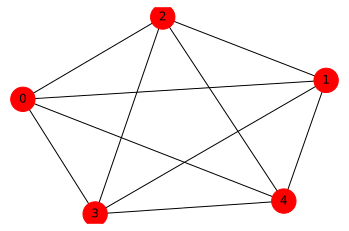

In [101]:
# Generate a complete, weighted graph with 5 nodes
n = 5
G = nx.complete_graph(n)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=False)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

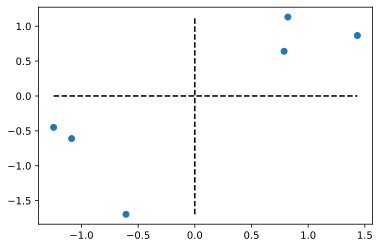

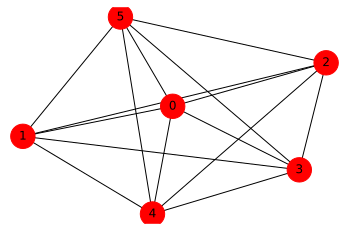

In [176]:
# Generate a graph instance with sample coreset data
coreset_points = []
# generate 3 points around x=-1, y=-1
for _ in range(3):
    # use a uniformly random weight
    #weight = np.random.uniform(0.1,5.0,1)[0]
    weight = 1
    vector = np.array([np.random.normal(loc=-1, scale=0.5, size=1)[0], np.random.normal(loc=-1, scale=0.5, size=1)[0]])
    new_point = (weight, vector)
    coreset_points.append(new_point)

# generate 3 points around x=+1, y=1
for _ in range(3):
    # use a uniformly random weight
    #weight = np.random.uniform(0.1,5.0,1)[0]
    weight = 1
    vector = np.array([np.random.normal(loc=1, scale=0.5, size=1)[0], np.random.normal(loc=1, scale=0.5, size=1)[0]])
    new_point = (weight, vector)
    coreset_points.append(new_point)

# Plot the coreset points
xx = [cp[1][0] for cp in coreset_points]
yy = [cp[1][1] for cp in coreset_points]
plt.scatter(xx, yy)
plt.hlines(0, np.amin(xx), np.amax(xx), ls='--')
plt.vlines(0, np.amin(yy), np.amax(yy), ls='--')
plt.show()
plt.close()

# Generate a networkx graph with correct edge weights
n = len(coreset_points)
G = nx.complete_graph(n)
for edge in G.edges():
    v_i = edge[0]
    v_j = edge[1]
    w_i = coreset_points[v_i][0]
    w_j = coreset_points[v_j][0]
    #dot_prod = np.dot(coreset_points[v_i][1], coreset_points[v_j][1])
    dist = np.linalg.norm(coreset_points[v_i][1] - coreset_points[v_j][1])
    G[v_i][v_j]['weight'] = w_i * w_j * dist
    
# Generate plot of the Graph
colors = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=False)
pos = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

In [177]:
# Create the quantum circuit to implement the QAOA
def evolve_cost(c, angle, G):
    for edge in G.edges():
        i = edge[0]
        j = edge[1]
        w = G[i][j]['weight']
        c.cx(i,j)
        c.rz(-2*angle*w, j)
        c.cx(i,j)
    
def evolve_driver(c, angle):
    c.rx(2*angle, c.qubits)
    
def gen_qaoa_circ(P, gamma, beta, G):
    """
    P (int) : number of layers to apply
    gamma (list[float]) : list with length p, contains angle parameters for cost Hamiltonian
    beta (list[float]) : list with length p, contains angle parameters for driver Hamiltonian
    G (graph) : NetworkX graph representing the MAXCUT problem instance
    """
    # create the quantum and classical registers
    n = len(G.nodes()) # get the number of vertices (qubits)
    circ = QuantumCircuit(n)
    
    # apply the initial layer of Hadamards
    circ.h(range(n))
    
    # iteratively apply the cost and driver unitaries p times
    for p in range(P):
        circ.barrier()
        evolve_cost(circ, gamma[p], G)
        circ.barrier()
        evolve_driver(circ, beta[p])
        
    # apply measurements to all qubits
    circ.measure_all()
    
    return circ

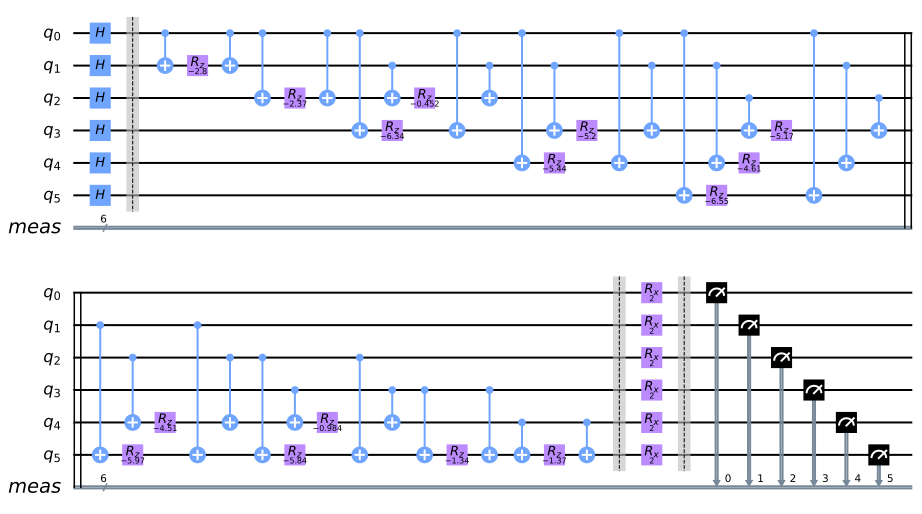

In [178]:
mycirc = gen_qaoa_circ(1, [1], [1], G)
mycirc.draw(output='mpl', scale=0.5)

In [179]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for edge in E:
        e1 = edge[0]
        e2 = edge[1]
        w = G[e1][e2]['weight']
        C = C + w*(x[e1]*(1-x[e2]) + x[e2]*(1-x[e1]))
        
    return C

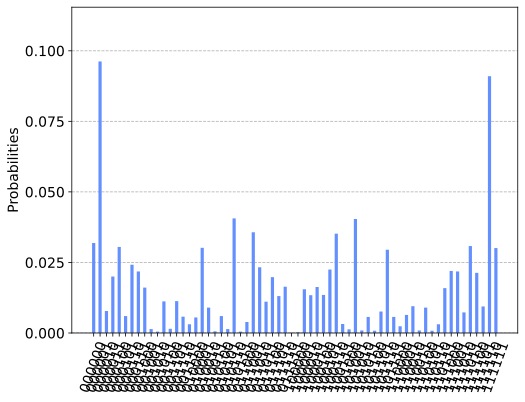

In [180]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(mycirc, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The approximate solution is x* = 111000 with C(x*) = 24 

The cost function is distributed as: 



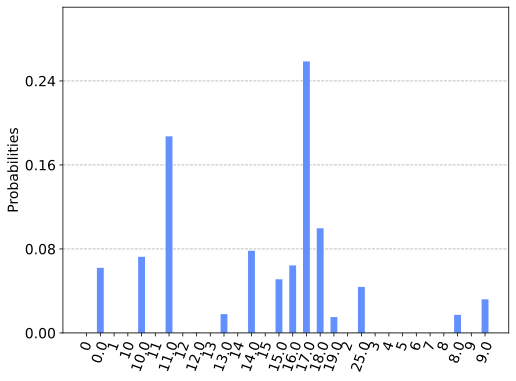

In [181]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
#print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Energy Landscape

In [182]:
# Use the circuit generator to estimate the energy landscape
step_size=0.05
P = 1
backend = Aer.get_backend("qasm_simulator")
shots = 10000

a_gamma = np.arange(0, np.pi, step_size)
a_beta  = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

estC = []
max_C = [0,-np.inf]
for gamma_list, beta_list in zip(a_gamma, a_beta):
    C_row = []
    for gamma, beta in zip(gamma_list, beta_list):
        qaoa_circ = gen_qaoa_circ(P, [gamma], [beta], G)

        simulate = execute(qaoa_circ, backend=backend, shots=shots)
        QAOA_results = simulate.result()
        
        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()

        avr_C = 0
        hist  = {}

        for k in range(len(G.edges())+1):
            hist[str(k)] = hist.get(str(k),0)

        for sample in list(counts.keys()):
            # use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function_C(x,G)
    
            # compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample]*tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
            
            # save best bit string
            if(max_C[1] < tmp_eng):
                max_C[0] = sample
                max_C[1] = tmp_eng
                
        M1_sampled   = avr_C/shots
        
        C_row.append(M1_sampled)
    estC.append(C_row)
estC = np.array(estC)

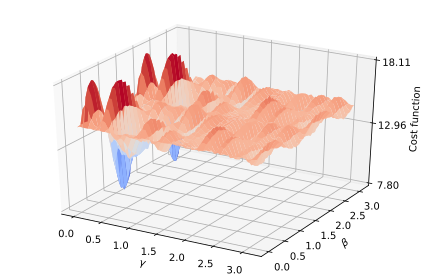


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  M1 = 18.114
This is attained for gamma = 1.850 and beta = 0.100
Best single partitioning and cost achieved were: 111000, C = 24.819
mu_plus: [-0.97974884 -0.918912  ]
mu_minus: [1.01402535 0.8796999 ]


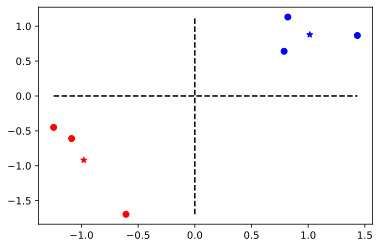

In [186]:
# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, estC, cmap=cm.coolwarm, linewidth=0, antialiased=True)

#ax.set_zlim(1,4)
#ax.set_xlim(3,6)
#ax.set_ylim(3,6)
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel('Cost function')
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.tight_layout()
plt.show()
plt.close()

result = np.where(estC == np.amax(estC))
a = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value (avg over {} shots) is:  M1 = {:.3f}'.format(shots, np.amax(estC)))
print('This is attained for gamma = {0:.3f} and beta = {1:.3f}'.format(gamma,beta))
print('Best single partitioning and cost achieved were: {}, C = {:.3f}'.format(max_C[0], max_C[1]))

# Plot the centroids according to the optimal partitioning
c_plus = 'red'
c_minus = 'blue'

S_plus = [coreset_points[i] for i in range(len(max_C[0])) if max_C[0][i] == '1']
xx_plus = [pt[1][0] for pt in S_plus]
yy_plus = [pt[1][1] for pt in S_plus]
plt.scatter(xx_plus, yy_plus, c=c_plus)

S_minus = [coreset_points[i] for i in range(len(max_C[0])) if max_C[0][i] == '0']
xx_minus = [pt[1][0] for pt in S_minus]
yy_minus = [pt[1][1] for pt in S_minus]
plt.scatter(xx_minus, yy_minus, c=c_minus)

mu_plus = np.sum([point[0]*point[1] for point in S_plus], axis=0) / np.sum([point[0] for point in S_plus])
mu_minus = np.sum([point[0]*point[1] for point in S_minus], axis=0) / np.sum([point[0] for point in S_minus])
print('mu_plus:',mu_plus)
print('mu_minus:',mu_minus)
plt.scatter(mu_plus[0], mu_plus[1], c=c_plus, marker='*')
plt.scatter(mu_minus[0], mu_minus[1], c=c_minus, marker='*')

plt.hlines(0, np.amin(xx), np.amax(xx), ls='--')
plt.vlines(0, np.amin(yy), np.amax(yy), ls='--')
plt.show()
plt.close()

In [82]:
# Use the circuit generator to estimate the energy landscape
step_size=0.001
P = 1
backend = Aer.get_backend("qasm_simulator")
shots = 10000

a_gamma = np.arange(1.8, 1.9, step_size)
a_beta  = np.arange(0.15, 0.25, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma, a_beta)

estC = []
for gamma_list, beta_list in zip(a_gamma, a_beta):
    C_row = []
    for gamma, beta in zip(gamma_list, beta_list):
        qaoa_circ = gen_qaoa_circ(P, [gamma], [beta], G)

        simulate = execute(qaoa_circ, backend=backend, shots=shots)
        QAOA_results = simulate.result()
        
        # Evaluate the data from the simulator
        counts = QAOA_results.get_counts()

        avr_C = 0
        hist  = {}

        for k in range(len(G.edges())+1):
            hist[str(k)] = hist.get(str(k),0)

        for sample in list(counts.keys()):
            # use sampled bit string x to compute C(x)
            x = [int(num) for num in list(sample)]
            tmp_eng = cost_function_C(x,G)
    
            # compute the expectation value and energy distribution
            avr_C = avr_C + counts[sample]*tmp_eng
            hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
                
        M1_sampled   = avr_C/shots
        C_row.append(M1_sampled)
    estC.append(C_row)
estC = np.array(estC)

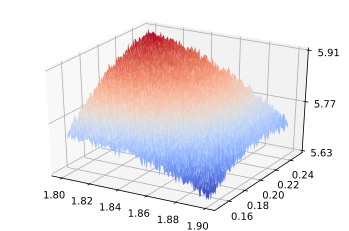

(array([97]), array([0]))
(97, 0)

 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 5.914
This is attained for gamma = 0.097 and beta = 0.000


In [83]:
# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, estC, cmap=cm.coolwarm, linewidth=0, antialiased=True)

#ax.set_zlim(1,4)
#ax.set_xlim(3,6)
#ax.set_ylim(3,6)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

result = np.where(estC == np.amax(estC))
print(result)
a = list(zip(result[0],result[1]))[0]
print(a)

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = {:.03f}'.format(np.amax(estC)))
print('This is attained for gamma = {0:.3f} and beta = {1:.3f}'.format(gamma,beta))

(32, 32)


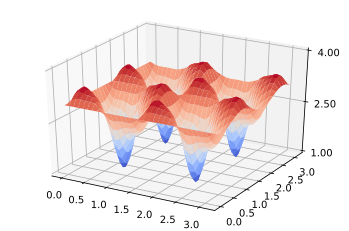


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.431
This is attained for gamma = 1.900 and beta = 0.200


In [58]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)

F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)
print(F1.shape)

# Grid search for the minimizing variables
result = np.where(F1 == np.amax(F1))
a      = list(zip(result[0],result[1]))[0]

gamma  = a[0]*step_size;
beta   = a[1]*step_size;

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))